## Spam Classification
In this notebook we demonstrate how to classify if an image is SPAM or HAM using the SMS Spam Collection Dataset which can be found [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset#spam.csv)


In [1]:
# To install only the requirements of this notebook, uncomment the lines below and run this cell

# ===========================

# !pip install pandas==1.1.5
# !pip install scikit-learn==0.21.3
# !pip install numpy==1.19.5
# !pip install wget==3.2
# !pip install fastai==1.0.60
# !pip install spacy==2.2.4

# ===========================

In [2]:
# To install the requirements for the entire chapter, uncomment the lines below and run this cell

# ===========================

# try:
#     import google.colab
#     !curl  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/ch4-requirements.txt | xargs -n 1 -L 1 pip install
# except ModuleNotFoundError:
#     !pip install -r "ch4-requirements.txt"

# ===========================

In [3]:
import pandas as pd
import wget
import os
from zipfile import ZipFile

In [4]:
# try :
#     from google.colab import files 
#     !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
#     !unzip smsspamcollection.zip
#     df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
# except ModuleNotFoundError :
#     url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
#     path = os.getcwd()+'\Data'
#     wget.download(url,path)
#     temp=path+'\smsspamcollection.zip'          
#     file = ZipFile(temp)           
#     file.extractall(path)          
#     file.close()
#     df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
path = '../Data'
# wget.download(url,path)
# temp=path+'\smsspamcollection.zip'          
# file = ZipFile(temp)           
# file.extractall(path)          
# file.close()
df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

In [5]:
# import fastai
from fastai import *
# from fastai.text import *
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [6]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

target
ham     0.865937
spam    0.134063
Name: count, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_train, df_test = train_test_split(df,stratify = df['target'], test_size = 0.2, random_state = 2020)

In [9]:
df_train.shape,df_test.shape

((4457, 2), (1115, 2))

In [10]:
df_train.head()
df_train.columns = ['label', 'text']
df_test.columns = ['label', 'text']
df_train.head()

,label,text
785,ham,Dont think so. It turns off like randomlly wit...
2613,ham,Yes. It's all innocent fun. O:-)
2605,ham,You call times job today ok umma and ask them ...
5406,ham,Dear are you angry i was busy dear
3761,ham,We'll join the &lt;#&gt; bus


In [11]:
# NOTE: These are all deprecated in fastai v=1.0, none exist in v=2. Some examples below of the new way to do it
# # Language model data 
# data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_test, path = "")  

# # Classifier model data 
# data_class = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

In [12]:
# print(df_train.batch_size)

In [13]:
# NOTE: New version of fastai, all these classes from the example have been deprecated, trying with the new version

from fastai.text.all import *

# Assuming you have pandas DataFrames named train_df and valid_df
texts_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=RandomSplitter(valid_pct=0.1, seed=42))

dls_texts = texts_lm.dataloaders(df_train, bs=64, seq_len=72)
dls_texts.show_batch(max_n=3)



Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


,text,text_
0,xxbos xxmaj er yep sure . xxmaj xxunk ? xxbos xxmaj sounds better than my evening i m just doing my xxunk . xxmaj i m not sure what time i finish tomorrow but i will txt you at the end . xxbos xxmaj am in xxunk xxunk college xxbos xxmaj it 's not that you make me cry . xxmaj it 's just that when all our stuff happens on top,xxmaj er yep sure . xxmaj xxunk ? xxbos xxmaj sounds better than my evening i m just doing my xxunk . xxmaj i m not sure what time i finish tomorrow but i will txt you at the end . xxbos xxmaj am in xxunk xxunk college xxbos xxmaj it 's not that you make me cry . xxmaj it 's just that when all our stuff happens on top of
1,xxunk from all b and q xxunk for xxunk xxunk in orange xxunk came up to me and asked if i wanted xxunk ? xxmaj so i got the first xxunk in ! ! xxbos xxmaj joy 's father is xxmaj john . xxmaj then xxmaj john is the xxup name of xxmaj joy 's father . xxmaj xxunk xxbos themob > yo yo yo - here comes a new selection of,from all b and q xxunk for xxunk xxunk in orange xxunk came up to me and asked if i wanted xxunk ? xxmaj so i got the first xxunk in ! ! xxbos xxmaj joy 's father is xxmaj john . xxmaj then xxmaj john is the xxup name of xxmaj joy 's father . xxmaj xxunk xxbos themob > yo yo yo - here comes a new selection of hot
2,your mobile 11mths+ ? xxmaj you are entitled to update to the latest colour camera mobile for xxmaj free ! xxmaj call xxmaj the xxmaj mobile xxmaj update xxmaj co xxup free on 08002986906 xxbos xxmaj oh ya ya . i remember da . . xxbos what number do u live at ? xxmaj is it 11 ? xxbos xxmaj hi . xxmaj happy xxmaj new xxmaj year . i do nt,mobile 11mths+ ? xxmaj you are entitled to update to the latest colour camera mobile for xxmaj free ! xxmaj call xxmaj the xxmaj mobile xxmaj update xxmaj co xxup free on 08002986906 xxbos xxmaj oh ya ya . i remember da . . xxbos what number do u live at ? xxmaj is it 11 ? xxbos xxmaj hi . xxmaj happy xxmaj new xxmaj year . i do nt mean


In [14]:
texts_clas = DataBlock(blocks=(TextBlock.from_df('text', seq_len=72, vocab=dls_texts.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=RandomSplitter(valid_pct=0.1, seed=42))
dls_clas = texts_clas.dataloaders(df_train, bs=64)
dls_clas.show_batch(max_n=3)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


,text,category
0,"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , xxunk the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you really do n't know me at all . xxmaj it was xxunk wednesday , but it was n't bad . xxmaj the problem i have with it is you xxup have the time to clean it , but you choose not to . xxmaj you skype , you take pictures , you sleep , you want to go out . i do n't mind a few things here and there , but when you do n't make the bed ,",ham
1,"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! ! '' . i felt special . xxmaj she askd me 4 lunch . xxmaj after lunch she invited me to her apartment . xxmaj we went there . xxmaj she said , '' do u mind if i go into the bedroom for a minute ? '' '' ok '' , i sed in a sexy mood . xxmaj she came out 5 minuts latr wid a cake … n xxmaj my xxmaj wife , xxmaj my xxmaj parents ,",ham
2,"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! ! '' . i felt special . xxmaj she askd me 4 lunch . xxmaj after lunch she invited me to her apartment . xxmaj we went there . xxmaj she said , '' do u mind if i go into the bedroom for a minute ? '' '' ok '' , i sed in a sexy mood . xxmaj she came out 5 minuts latr wid a cake … n xxmaj my xxmaj wife , xxmaj my xxmaj parents ,",ham


In [15]:
# df_test

TextLMDataBunch applies some text preprocessing tasks to help the algorithm perform better. Altough we commonly remove stoopwords and punctuations, here we do not do it. This model can handle semantics, deleting such information might do more harm than good with respect to accuracy

Now lets look at our training data


In [16]:
# data_lm.show_batch()

Those 'xxmaj','xxbos', 'xxup' etc are all special tokens for the NN. xxbos stands for begin of sentence, xxmaj indicates that the first letter of the next word is in capital letter, 'xxup' is used to indicate the entire  next word is in captital letters. You can view the entire set of tokens [here.](https://docs.fast.ai/text.transform.html)

In [17]:
# model = language_model_learner(texts_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.5)
learn_lm = language_model_learner(dls_texts, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()])


We will use a pretrained model. You can learn more about it [here.](https://docs.fast.ai/text.models.html#Language-model-modules)

Now lets test our language model. Its is giving sensible outputs as it is pre trained on wiki corpus. 


In [18]:
for i in range(3):
    print(learn_lm.predict("The food is", n_words=15))

The food is played in the New Year 's Eve holiday in New


The food is green , which is the center of the food along or in the food .


The food is tampa and fever and the same weekend that London , England ,


We will now need to fine tune our model for our particular task. <br>

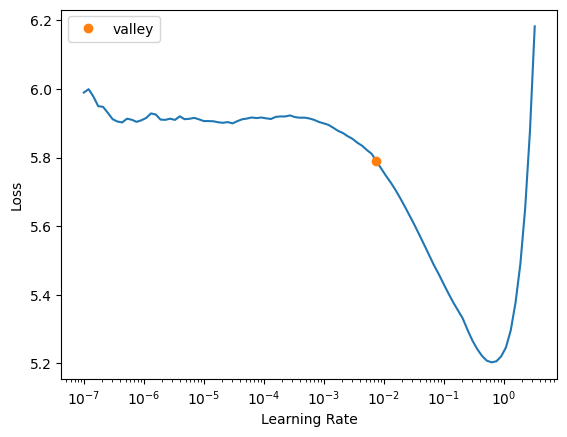

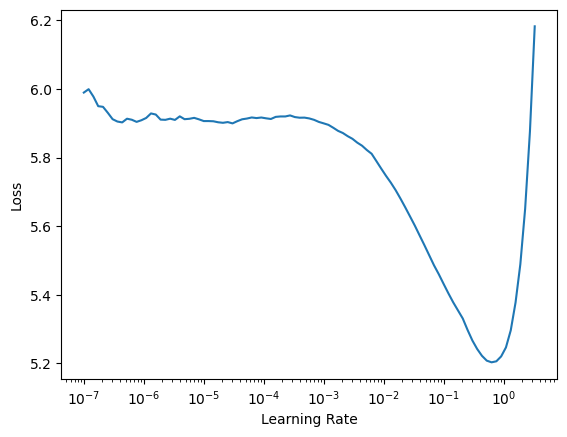

In [19]:
learn_lm.lr_find() # you can find more details about this at https://docs.fast.ai/basic_train.html
# learn_lm.model.plot(suggestion=True)
learn_lm.recorder.plot_lr_find()
# learn_lm.model.plot_losses(suggestion=True)

In [20]:
learn_lm.fit_one_cycle(4, lr_max= 5e-02)#you can freeze and unfreeze different layers and by doing so we can have different lr for each layer
#for freezing and unfreezing code you can refer https://docs.fast.ai/text.html


In [21]:
for i in range(3):
    print(learn_lm.predict("The food is", n_words=15))

The food is fixed with food . When on the way Offer order representative flights to


The food is that food needs food and food are important ones . Talking chinese food is


The food is a part of the social content system and is now closed . Food is


Note that now the model is predicting ':)' and other such characters which can generally be seen in SMS messages. With further more fine tuning and running it for more cyles you can get the model to predict more characters which are found in SMS messages.

In [22]:
# certainly learns something witha few mistakes
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM)
res=learn_clas.show_results()

,text,category,category_
0,"xxbos i know you are thinkin malaria . xxmaj but relax , children ca nt handle malaria . xxmaj she would have been worse and its xxunk . xxmaj if she takes enough to xxunk her loss her xxunk will xxunk . xxmaj and if you give her malaria meds now she will just vomit . xxmaj its a self xxunk xxunk she has which means in a few days it will completely stop",ham,spam
1,"xxbos xxmaj sir , good morning . xxmaj hope you had a good weekend . i called to let you know that i was able to raise < # > from my dad . xxmaj he however said he would make the rest available by mid feb . xxmaj this amount is still quite short and i was hoping you would help . xxmaj do have a good day . xxmaj abiola",ham,spam
2,xxbos xxup hiya xxup comin 2 xxup xxunk 1 xxup st xxup week xxup in xxup april . xxup xxunk xxup got xxup off + xxup xxunk xxup on xxup new xxup yrs xxup eve xxup but i xxup was xxup xxunk xxup were xxup drunk ! u xxup bak xxup at xxup college xxup yet ? xxup my xxup work xxup xxunk xxup xxunk 2 xxup bath .,ham,ham
3,"xxbos xxmaj thank you so much . xxmaj when we xxunk wit xxunk and sura , we did nt get the pleasure of your company . xxmaj hope you are good . xxmaj we 've xxunk you xxunk oh ! xxmaj we are xxunk down to xxunk . xxmaj enjoy ! xxmaj this is the message i sent days ago",ham,spam
4,xxbos xxmaj oh shut it . xxmaj omg yesterday i had a dream that i had 2 kids both boys . i was so pissed . xxmaj not only about the kids but them being boys . i even told mark in my dream that he was xxunk xxunk cause xxmaj i 'm not getting xxunk in the face .,ham,spam
5,xxbos xxmaj what do u want when i come xxunk beautiful xxunk as a xxunk of my heart for xxunk what i will give but xxup only to xxup my xxup wife xxup of xxup my xxup xxunk xxup that xxup and xxup see .. no xxup one can give you xxunk call me.i will wait till i come .,ham,spam
6,"xxbos xxup you xxup ve xxup won ! xxmaj your 4 * xxmaj costa xxmaj del xxmaj sol xxmaj holiday or £ 5 xxrep 3 0 await collection . xxmaj call 09050090044 xxmaj now toclaim . xxup sae , xxup tc s , pobox334 , xxmaj stockport , sk38xh , xxmaj cost£1.50 / pm , xxmaj max10mins",spam,spam
7,"xxbos xxmaj when i was born , xxup god said , "" oh xxmaj no ! xxmaj another xxup idiot "" . xxmaj when you were born , xxup god said , "" oh xxmaj no ! xxup competition "" . xxmaj who knew , one day these two will become xxup xxunk xxup forever !",ham,spam
8,"xxbos xxmaj xxunk people are xxunk the xxunk opportunity for xxunk of xxunk … . xxmaj have you ever xxunk xxunk ur books for the xxunk xxunk of xxunk ? xxmaj it is very xxunk , i think it is xxunk .. xxmaj xxunk xxmaj ur xxmaj opinion xxrep 4 ? xxmaj xxunk",ham,spam
